[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/tobyrmanders/statistical-rethinking/blob/main/code/chapter_05.ipynb)

In [1]:
import torch
from torch import tensor
import torch.distributions.constraints as constraints

import pyro
from pyro import distributions as dist
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import svi, Predictive
from pyro import optim
import pyro.ops.stats as stats


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rethinking import MAP, coef, extract_samples, link, precis, sim, vcov

# Easy

## 5E1

2, 4

## 5E2

$
D_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha + \beta_P * P_i  + \beta_L * L_i \\
$

## 5E3

$
T_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha + \beta_S * S_i  + \beta_T * T_i \\
$

Both slopes are positive.

## 5E4

1, 3, 4, 5?

# Medium

## 5M1

Strength as predicted by lean body mass and age. 

## 5M2

Basketball ranking as predicted by hand size and arachnodactyly. 

## 5M3

Divorced people remarry. The threshold to get married may be lower as a result of culturally accepted divorce -- i.e. less perceived commitment. While complementary data such as surveys on thoughts about divorce or longitudinal data of marriage and remarriage might paint a better picture, causal inference is probably difficult here. 

## 5M4

In [3]:
d = pd.read_csv('../data/WaffleDivorce.csv', sep=';')
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
lds = pd.read_html('https://www.pewresearch.org/religion/religious-landscape-study/religious-tradition/mormon/')[0]
lds.head()

,State,% of adults (2014),Total State Sample
0,Alabama,1%,511
1,Alaska,5%,310
2,Arizona,5%,653
3,Arkansas,1%,311
4,California,1%,3697


In [10]:
lds['lds_pct'] = lds['% of adults (2014)'].str.split('%').str[0].replace('< 1', '0')
d = d.merge(lds, left_on='Location', right_on='State')
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,State,% of adults (2014),Total State Sample,pct,lds_pct
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,Alabama,1%,511,1,1
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,Alaska,5%,310,5,5
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,Arizona,5%,653,5,5
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,Arkansas,1%,311,1,1
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,California,1%,3697,1,1


In [23]:
from sklearn.preprocessing import scale
t = torch.tensor(scale(d[['Divorce', 'Marriage', 'MedianAgeMarriage', 'lds_pct']]), dtype=float)
d_std, m_std, a_std, l_std  = t[:,0], t[:,1], t[:,2], t[:,3],
divorce = torch.tensor(d.Divorce, dtype=float)

In [24]:
pyro.clear_param_store()
def model(marriage, median_age_marriage, lds, divorce):
    a = pyro.sample("a", dist.Normal(10, 10))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    bA = pyro.sample("bA", dist.Normal(0, 1))
    bL = pyro.sample("bL", dist.Normal(0, 1))
    mu = a + bR * marriage + bA * median_age_marriage + bL * lds
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("data"):
        pyro.sample("Divorce", dist.Normal(mu, sigma), obs=divorce)

Elbo loss: 241.04761142887384
Elbo loss: 182.22193091813017
Elbo loss: 172.81403261040327
Elbo loss: 160.99588792830656
Elbo loss: 146.62877102947033
Elbo loss: 124.43713355664602
Elbo loss: 103.21587316554564
Elbo loss: 98.8421629866791
Elbo loss: 100.23993274518268
Elbo loss: 98.44065604889771


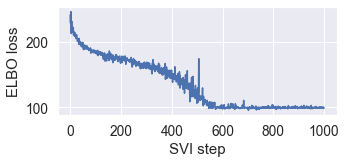

In [25]:
pyro.clear_param_store()

auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(m_std, a_std, l_std, divorce)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [26]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(m_std, a_std, l_std, divorce)

In [34]:
res = {k: v.detach().numpy() for k, v in samples.items()}

In [35]:
posterior = pd.DataFrame.from_dict(res)

In [36]:
posterior

,a,bR,bA,bL,sigma
0,10.053417,-0.045199,-1.540528,-0.648976,1.561829
1,9.660554,-0.004581,-1.098480,-0.527793,1.850508
2,9.795877,-0.095725,-1.064668,-0.443461,1.362004
3,9.534385,0.048744,-1.371109,-0.532510,1.841509
4,9.468480,0.323864,-1.173243,-0.281130,1.395974
...,...,...,...,...,...
795,9.544024,0.019176,-1.044508,-0.201914,1.622833
796,9.857675,0.080374,-1.477430,-0.362556,1.765668
797,9.676285,-0.424399,-1.233480,-0.340407,1.743265
798,9.960518,0.044981,-1.014124,-0.435058,1.488511


<AxesSubplot:>

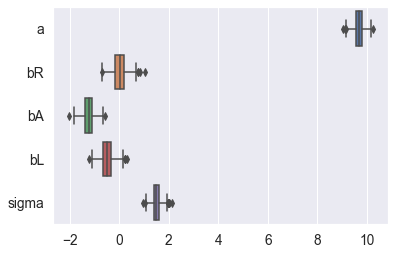

In [38]:
sns.boxplot(data=posterior, orient='h')

## 5M5

These hypotheses could be evaluated with the following predictor variables: rate of dining out, rate of exercise. Multiple regression with obesity (e.g. BMI) as an estimand, and gas price, dining out, and exercise as predictors, could reveal spurious waffles. 

## 5H1

This DAG implies that D is conditionally indpendent of M given A, and M is conditionaly independent of D given A. The plot from section 5.1.4 suggests that the data is consistent with this DAG, since the slope for M in the multiple regression model is close to zero.